- add tag to specify tissue and tool of models generated by isoquant and lyric from wing and leg of Lycaena helle
- combine models 
- quantify novelty
- run SQANTI
- include the resulting annotation to the overlapping analysis

In [102]:
import pyranges as pr
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt

# Add tag

In [1]:
models = ! ls ../data/longread_models/filtered/*corrected.gtf

In [3]:
models

['../data/longread_models/filtered/Lh_leg_iqfree_sqanti_filter_corrected.gtf',
 '../data/longread_models/filtered/Lh_leg_lyric_sqanti_filter_corrected.gtf',
 '../data/longread_models/filtered/Lh_wing_iqfree_sqanti_filter_corrected.gtf',
 '../data/longread_models/filtered/Lh_wing_lyric_sqanti_filter_corrected.gtf']

In [4]:
for m in models:
    
    tool = m.split('/')[-1].split('_')[2]
    tissue = m.split('/')[-1].split('_')[1]
    out_file = m.replace('.gtf', '_plusTAG.gtf')
    
    pr_obj = pr.read_gtf(m)
    df_obj = pr_obj.df
    df_obj['tool'] = tool
    df_obj['tissue'] = tissue
    
    modified_pr_obj = pr.PyRanges(df_obj)
    modified_pr_obj.to_gtf(out_file)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

# Merge models
This is will be done inside the agat container

```
docker run --platform linux/amd64 -v $PWD:$PWD -w $PWD -ti quay.io/biocontainers/agat:1.4.0--pl5321hdfd78af_0

agat_sp_merge_annotations.pl \
        --gff filtered/Lh_leg_iqfree_sqanti_filter_corrected_plusTAG.gtf \
        --gff filtered/Lh_leg_lyric_sqanti_filter_corrected_plusTAG.gtf \
        --gff filtered/Lh_wing_iqfree_sqanti_filter_corrected_plusTAG.gtf \
        --gff filtered/Lh_wing_lyric_sqanti_filter_corrected_plusTAG.gtf \
        --out combined_models/Lh_leg_wing_iqfree_lyric_merged_plusTAG.gff

```

In [5]:
! ls ../data/longread_models/combined_models/Lh_leg_wing_iqfree_lyric_merged_plusTAG.gff

../data/longread_models/combined_models/Lh_leg_wing_iqfree_lyric_merged_plusTAG.gff


### Refine annotation

This consist of rename genes and child feature so they follow a coherent pattern instead of mix of lyric and isoquant names. 

```
docker run --platform linux/amd64 -v $PWD:$PWD -w $PWD -ti quay.io/biocontainers/agat:1.4.0--pl5321hdfd78af_0

agat_sp_manage_IDs.pl --type_dependent --gff Lh_leg_wing_iqfree_lyric_merged_plusTAG.gff -o Lh_leg_wing_iqfree_lyric_merged_plusTAG_newID.gff

```

`--type_dependent` allows to have feature specific counting.
This can be achieved also with `agat_sq_manage_ID.pl` and no ption, but the utility doesn't give the flexibility of the `SP` version. 

In [2]:
! head ../data/longread_models/combined_models/Lh_leg_wing_iqfree_lyric_merged_plusTAG_newID.gff

##gff-version 3
ilHelHell1.1_ChrW	tmerge	gene	1338785	1339153	0	-	.	ID=gene-1;gene_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210;tissue=wing;tool=lyric;transcript_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210
ilHelHell1.1_ChrW	tmerge	transcript	1338785	1339153	0	-	.	ID=transcript-1;Parent=gene-1;gene_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210;tissue=wing;tool=lyric;transcript_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210
ilHelHell1.1_ChrW	tmerge	exon	1338785	1338964	0	-	.	ID=exon-1;Parent=transcript-1;gene_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210;tissue=wing;tool=lyric;transcript_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210
ilHelHell1.1_ChrW	tmerge	exon	1339031	1339153	0	-	.	ID=exon-2;Parent=transcript-1;gene_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210;tissue=wing;tool=lyric;transcript_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676210
ilHelHell1.1_ChrZ	tmerge	gene	137166	142702	0	+	.	ID=gene-2;gene_id=ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000002676266

In [24]:
def get_set(x):
    
    """get a set of unique elements from string and ignores whitespaces"""
    if pd.isna(x):
        return np.nan
    
    elements = x.split(',')
    final_list = set(filter(lambda s: s.strip(), elements))
    final_string = ','.join(final_list)            
    
    return final_string
    

In [4]:
def merge_cols(df, merge_into, merge_from):
    
    """retunrs a copy of df where "merge_from" column's elements are merged into "merge_into" """
    """the into colums is removed and from column is substitued """
    
    local_df = df.copy()
    c = local_df[merge_into]+','+local_df[merge_from].fillna('')
    local_df[merge_into] = c.map(get_set)
    local_df = local_df.drop(merge_from, axis=1)

    return local_df   


In [5]:
def transfer_to_child(df, parent, tag_to_transfer):
    
    """This returns a df where a tag to transfer is copied from the parent feature to all child features."""
    """It is useful when merging GFF and not all tags are properly combined."""
    """This assumes no more than one parent per child."""

    local_df = df.copy()
    all_parents = local_df[local_df.Feature == parent].ID.unique()
    for p in all_parents:
        tag_info = local_df[local_df.ID == p][tag_to_transfer].values[0]
        local_df.loc[local_df['Parent'] == p, tag_to_transfer] = tag_info
    
    return local_df
    

In [25]:
merged_fixedID = pr.read_gff3('../data/longread_models/combined_models/Lh_leg_wing_iqfree_lyric_merged_plusTAG_newID.gff')
merged_fixedID_df = merged_fixedID.df

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [26]:
merged_fixedID_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,ID,gene_id,...,tool,transcript_id,Parent,merged_ID,merged_Parent,merged_gene_id,merged_tissue,merged_tool,merged_transcript_id,merged_score
0,ilHelHell1.1_Chr1,tmerge,gene,78264,78789,0,+,.,gene-261,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,...,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ilHelHell1.1_Chr1,tmerge,transcript,78264,78789,0,+,.,transcript-835,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,...,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,gene-261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ilHelHell1.1_Chr1,tmerge,exon,78264,78334,0,+,.,exon-4695,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,...,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,transcript-835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ilHelHell1.1_Chr1,tmerge,exon,78661,78789,0,+,.,exon-4696,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,...,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,transcript-835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ilHelHell1.1_Chr1,IsoQuant,gene,108440,111334,0,+,.,gene-262,"novel_gene_ilHelHell1.1_Chr1_4,novel_gene_ilHe...",...,"iqfree,lyric","transcript3.ilHelHell1.1_Chr1.nnic,transcript1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174618,ilHelHell1.1_ChrZ,IsoQuant,exon,25976574,25976980,.,-,.,exon-4657,novel_gene_ilHelHell1.1_ChrZ_4879,...,iqfree,transcript4878.ilHelHell1.1_ChrZ.nnic,transcript-821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174619,ilHelHell1.1_ChrZ,IsoQuant,transcript,25967538,25977070,.,-,.,transcript-822,novel_gene_ilHelHell1.1_ChrZ_7682,...,iqfree,transcript7681.ilHelHell1.1_ChrZ.nnic,gene-255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174620,ilHelHell1.1_ChrZ,IsoQuant,exon,25967538,25967885,.,-,.,exon-4658,novel_gene_ilHelHell1.1_ChrZ_7682,...,iqfree,transcript7681.ilHelHell1.1_ChrZ.nnic,transcript-822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174621,ilHelHell1.1_ChrZ,IsoQuant,exon,25976086,25976501,.,-,.,exon-4659,novel_gene_ilHelHell1.1_ChrZ_7682,...,iqfree,transcript7681.ilHelHell1.1_ChrZ.nnic,transcript-822,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
merged_fixedID_df.columns

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'ID', 'gene_id', 'tissue', 'tool', 'transcript_id', 'Parent',
       'merged_ID', 'merged_Parent', 'merged_gene_id', 'merged_tissue',
       'merged_tool', 'merged_transcript_id', 'merged_score'],
      dtype='object')

In [29]:
merged_fixedID_df =  merge_cols(merged_fixedID_df, 'tissue', 'merged_tissue')
merged_fixedID_df =  merge_cols(merged_fixedID_df, 'tool', 'merged_tool')
merged_fixedID_df =  merge_cols(merged_fixedID_df, 'gene_id', 'merged_gene_id')
merged_fixedID_df =  merge_cols(merged_fixedID_df, 'transcript_id', 'merged_transcript_id')

In [30]:
merged_fixedID_df.columns

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'ID', 'gene_id', 'tissue', 'tool', 'transcript_id', 'Parent',
       'merged_ID', 'merged_Parent', 'merged_score'],
      dtype='object')

In [31]:
# remove manually merged_ID and merged_Parent as they don't have to be merged
merged_fixedID_df = merged_fixedID_df.drop(['merged_ID' ,'merged_Parent','merged_score'], axis=1)

In [13]:
# This MUST be optimised
# merged_fixedID_df = transfer_to_child(merged_fixedID_df, 'transcript', 'gene_id')
# merged_fixedID_df = transfer_to_child(merged_fixedID_df, 'transcript', 'transcript_id')
# merged_fixedID_df = transfer_to_child(merged_fixedID_df, 'transcript', 'tissue')
# merged_fixedID_df = transfer_to_child(merged_fixedID_df, 'transcript', 'tool')

# Quantify novelty

In [32]:
merged_fixedID_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,ID,gene_id,tissue,tool,transcript_id,Parent
0,ilHelHell1.1_Chr1,tmerge,gene,78264,78789,0,+,.,gene-261,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,wing,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,NaN
1,ilHelHell1.1_Chr1,tmerge,transcript,78264,78789,0,+,.,transcript-835,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,wing,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,gene-261
2,ilHelHell1.1_Chr1,tmerge,exon,78264,78334,0,+,.,exon-4695,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,wing,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,transcript-835
3,ilHelHell1.1_Chr1,tmerge,exon,78661,78789,0,+,.,exon-4696,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,wing,lyric,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000001,transcript-835
4,ilHelHell1.1_Chr1,IsoQuant,gene,108440,111334,0,+,.,gene-262,ont-Crg-xx_Lycaena_0+_Wing.NAM_TM_000000000005...,"wing,leg","iqfree,lyric","transcript11.ilHelHell1.1_Chr1.nnic,ont-Crg-xx...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174618,ilHelHell1.1_ChrZ,IsoQuant,exon,25976574,25976980,.,-,.,exon-4657,novel_gene_ilHelHell1.1_ChrZ_4879,wing,iqfree,transcript4878.ilHelHell1.1_ChrZ.nnic,transcript-821
174619,ilHelHell1.1_ChrZ,IsoQuant,transcript,25967538,25977070,.,-,.,transcript-822,novel_gene_ilHelHell1.1_ChrZ_7682,leg,iqfree,transcript7681.ilHelHell1.1_ChrZ.nnic,gene-255
174620,ilHelHell1.1_ChrZ,IsoQuant,exon,25967538,25967885,.,-,.,exon-4658,novel_gene_ilHelHell1.1_ChrZ_7682,leg,iqfree,transcript7681.ilHelHell1.1_ChrZ.nnic,transcript-822
174621,ilHelHell1.1_ChrZ,IsoQuant,exon,25976086,25976501,.,-,.,exon-4659,novel_gene_ilHelHell1.1_ChrZ_7682,leg,iqfree,transcript7681.ilHelHell1.1_ChrZ.nnic,transcript-822


In [33]:
tools = merged_fixedID_df.tool.unique()
tissues =  merged_fixedID_df.tissue.unique()

In [34]:
tools

array(['lyric', 'iqfree,lyric', 'iqfree'], dtype=object)

In [35]:
all_combinations = list(itertools.product(tools, tissues))

In [36]:
all_combinations

[('lyric', 'wing'),
 ('lyric', 'wing,leg'),
 ('lyric', 'leg'),
 ('iqfree,lyric', 'wing'),
 ('iqfree,lyric', 'wing,leg'),
 ('iqfree,lyric', 'leg'),
 ('iqfree', 'wing'),
 ('iqfree', 'wing,leg'),
 ('iqfree', 'leg')]

In [96]:
summary_dict = {}
merged_summary = pd.DataFrame(columns=tissues, index=tools)

for ft in ['gene', 'transcript']:

    summary_dict[ft+'_count'] = merged_summary.copy()
    summary_dict[ft+'_perc'] = merged_summary.copy()
    tmp_df = merged_fixedID_df[merged_fixedID_df.Feature == ft]
    summary_dict[ft+'_total'] = len(tmp_df)
    
    for c in all_combinations:
        tool = c[0]
        tissue = c[1]
        summary_dict[ft+'_count'].loc[tool,tissue] =  len(tmp_df[(tmp_df.tool == tool) & (tmp_df.tissue == tissue)])
        summary_dict[ft+'_count'] = summary_dict[ft+'_count'].apply(pd.to_numeric, errors='coerce')
        
        summary_dict[ft+'_perc'].loc[tool,tissue] = round(summary_dict[ft+'_count'].loc[tool,tissue]/summary_dict[ft+'_total'],2)
        summary_dict[ft+'_perc'] = summary_dict[ft+'_perc'].apply(pd.to_numeric, errors='coerce')

In [97]:
summary_dict

{'gene_count':                 wing  wing,leg    leg
 lyric         1681.0     842.0  411.0
 iqfree,lyric   533.0    3504.0  360.0
 iqfree         163.0      80.0  116.0,
 'gene_perc':               wing  wing,leg   leg
 lyric         0.22      0.11  0.05
 iqfree,lyric  0.07      0.46  0.05
 iqfree        0.02      0.01  0.02,
 'gene_total': 7690,
 'transcript_count':                 wing  wing,leg     leg
 lyric         9539.0     585.0  8607.0
 iqfree,lyric   858.0     532.0   737.0
 iqfree        4249.0     448.0  3872.0,
 'transcript_perc':               wing  wing,leg   leg
 lyric         0.32      0.02  0.29
 iqfree,lyric  0.03      0.02  0.03
 iqfree        0.14      0.02  0.13,
 'transcript_total': 29427}

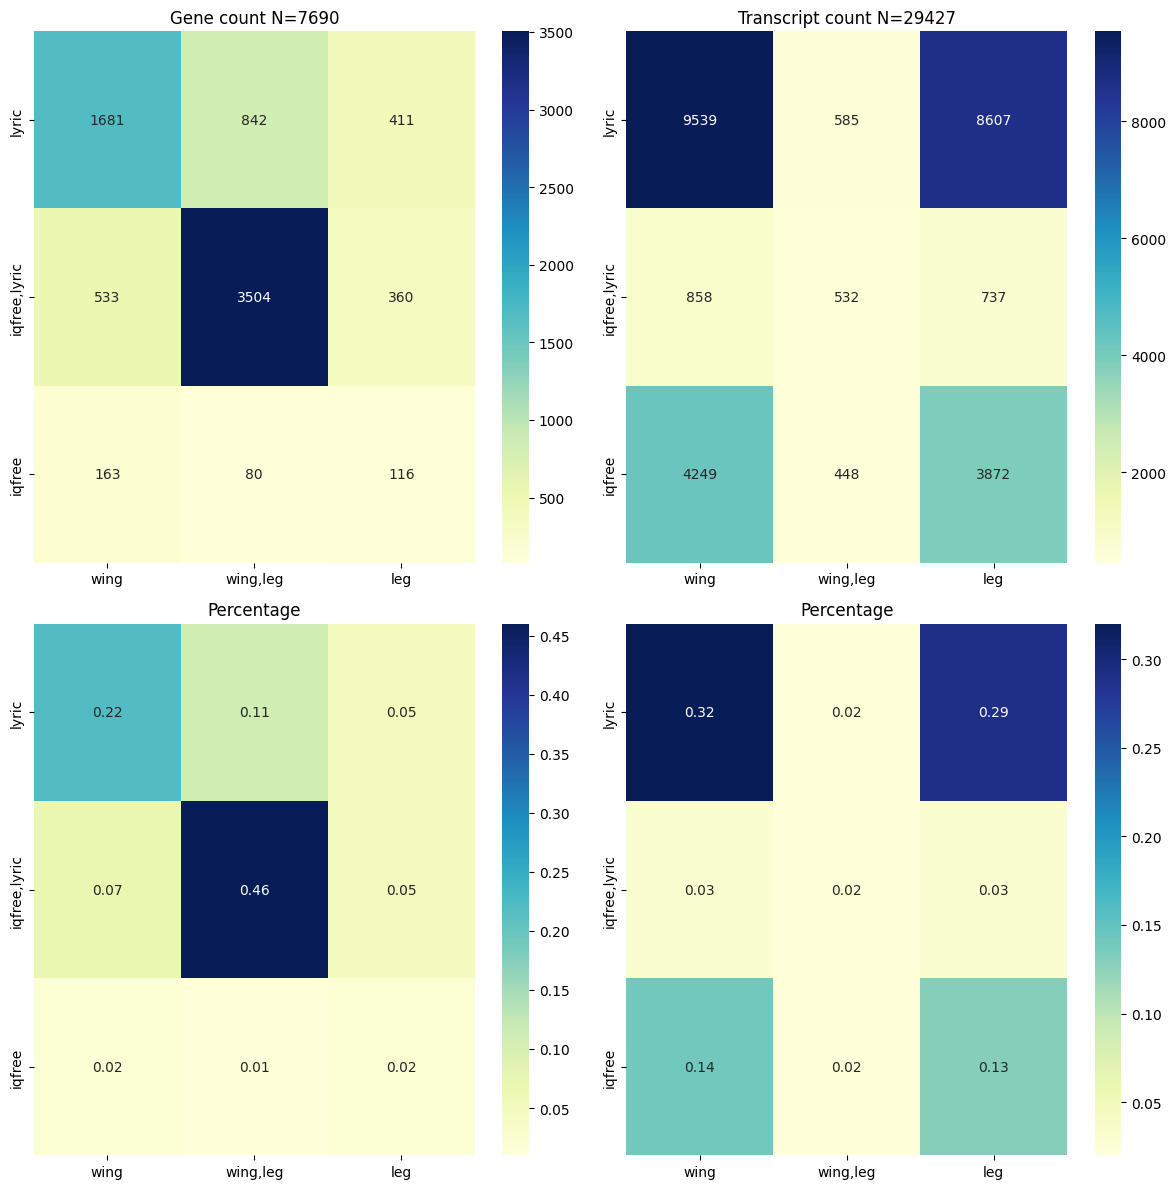

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.heatmap(summary_dict['gene_count'], annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0, 0])
axes[0, 0].set_title(f'Gene count N={summary_dict['gene_total']}')

sns.heatmap(summary_dict['transcript_count'], annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0, 1])
axes[0, 1].set_title(f'Transcript count N={summary_dict['transcript_total']}')

sns.heatmap(summary_dict['gene_perc'], annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1, 0])
axes[1, 0].set_title('Percentage')

sns.heatmap(summary_dict['transcript_perc'], annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1, 1])
axes[1, 1].set_title('Percentage')

plt.tight_layout()
plt.show()